<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Heatmap_each.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program generates one heatmap for each landmark, while `Heatmap_all.ipynb` generates one heatmap for all landmarks.

* 不要用 Gaussian 做 Label，匹配 Loss Function 的形状，保证理论上误差为0.


# 1. Initialize

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Procruses Analysis.ipynb',
 'PCA.ipynb',
 '__pycache__',
 'utils',
 'datasets',
 'Gaussian.ipynb',
 'Heatmap_all.ipynb',
 'DataPreprocessing.ipynb',
 'hourglass',
 'Heatmap_each.ipynb',
 'trained_models']

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim


import warnings
warnings.filterwarnings('ignore')


In [3]:
from utils.hourglass import *
from utils.dataloader import *

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2. Data Loader

In [5]:
helen_trainset = Helen_set(dataset_type="train")

Loading [1/2000] pictures......
Loading [400/2000] pictures......
Loading [800/2000] pictures......
Loading [1200/2000] pictures......
Loading [1600/2000] pictures......
Loading [2000/2000] pictures......


In [6]:
helen_testset = Helen_set(dataset_type="test")

Loading [1/330] pictures......
Loading [200/330] pictures......


In [7]:
train_dataloder = DataLoader(helen_trainset, batch_size=30)
test_dataloder = DataLoader(helen_testset, batch_size=30)

# 3. Pre Train

In [5]:
helen_sampleset = Helen_set(dataset_type="sample")
sample_dataloder = DataLoader(helen_sampleset, batch_size=20)

Loading [1/200] pictures......
Loading [100/200] pictures......
Loading [200/200] pictures......


In [6]:
critical = torch.nn.MSELoss()

nIters = 200
HGNet = HGNet().to(device)
optimizer = optim.SGD(HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

Iter [1/20] loss 0.4862
Iter [10/20] loss 0.3855
Iter [20/20] loss 0.3303


Text(0.5, 1.0, 'Training Loss')

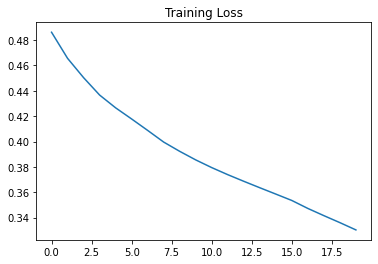

In [7]:
loss_hist = torch.zeros(nIters)
loss_epoch = torch.zeros(10)

for iter in range(nIters):
  for i, (x,_,y) in enumerate(sample_dataloder):
    x = Variable(x,requires_grad=True).float().to(device)
    y = Variable(y).float().to(device)
    y_pred = HGNet.forward(x)
    loss = critical(y_pred, y)
    loss_epoch[i] = loss.item()

    if i == 9:
      loss_avg = torch.sum(loss_epoch)/10
      loss_hist[iter] = loss_avg
      if (iter+1)%10 == 0 or iter == 0:
        print('Iter [%d/%d] loss %.4f' %(iter+1, nIters, loss_avg))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(torch.arange(nIters),loss_hist.detach().numpy())
plt.title("Training Loss")

In [8]:
# torch.save(HGNet.state_dict(), "/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt")

# 4. Tune Training

## 4.1 Functions

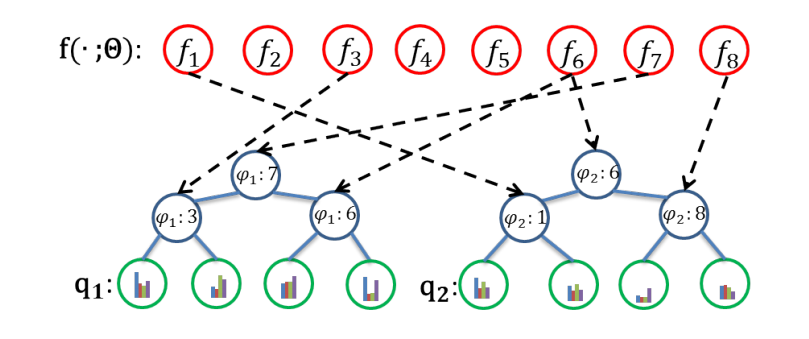

In [ ]:
def phi(cnn_fc):
  device = cnn_fc.device
  N,C = cnn_fc.shape
  out = torch.zeros(N,C).to(device)

  phi1l = cnn_fc[:,2]*torch.sigmoid(cnn_fc[:,6])
  phi1r = cnn_fc[:,5]*(1-torch.sigmoid(cnn_fc[:,6]))
  phi2l = cnn_fc[:,0]*torch.sigmoid(cnn_fc[:,5])
  phi2r = cnn_fc[:,7]*(1-torch.sigmoid(cnn_fc[:,5]))

  out[:,0] = torch.sigmoid(phi1l)
  out[:,1] = 1-torch.sigmoid(phi1l)
  out[:,2] = torch.sigmoid(phi1r)
  out[:,3] = 1-torch.sigmoid(phi1r)
  out[:,4] = torch.sigmoid(phi2l)
  out[:,5] = 1-torch.sigmoid(phi2l)
  out[:,6] = torch.sigmoid(phi2r)
  out[:,7] = 1-torch.sigmoid(phi2r)

  return out

## 4.2 Sample Set

In [5]:
helen_sampleset = Helen_set(dataset_type="sample")
sample_dataloder = DataLoader(helen_sampleset, batch_size=20)

Loading [1/200] pictures......
Loading [100/200] pictures......
Loading [200/200] pictures......


## 4.3 Network

In [6]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet.load_state_dict(torch.load("/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt"))

<All keys matched successfully>

In [8]:
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(64,128,128)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,64,64)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2))  #(4,32,32)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*32*32,4*32),
                    nn.Linear(4*32,8),
                    nn.ReLU(inplace=True))

## 4.4 Training

In [ ]:
#######################
# Initialization
Total_train = 10

# CNN initilization
nIters = 200

criterion = torch.nn.MSELoss()
optimizer = optim.SGD(Tune_HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [ ]:
loss_hist = torch.zeros(nIters)
loss_epoch = torch.zeros(10)

for round in range(Total_train):
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)
  
  #####################################
  ### Train Regression Trees
  #####################################
  if round == 0:
    leaf_q = torch.ones(8,12*224*224).to(device)/(224*224)
    cnn_prob = torch.ones(train_size,8).to(device)/8
  

  with torch.no_grad():
    pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q))
    loss0 = torch.sum(torch.abs(pred_coord0-train_label[:,72:96]))

    htrain_reshape = heatmap_train_label[:,36:48,:].reshape(train_size,-1) #(200,68*224*224)
    leaf_q = torch.matmul(torch.linalg.pinv(cnn_prob), htrain_reshape) #(8,68*224*224)

    pred_coord1 = find_coord(torch.matmul(cnn_prob,leaf_q))
    loss1 = torch.sum(torch.abs(pred_coord1-train_label[:,72:96]))
    print("     RF training, coordinate loss: %.4f -> %.4f" %(loss0, loss1))
  
  #####################################
  ### Train Hourglass
  #####################################

  for iter in range(nIters):
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = Variable(x,requires_grad=True).float().to(device)
      y = Variable(y).float().to(device)
      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)
      

      loss = criterion(y_pred, y)
      loss_epoch[i] = loss.item()
      if (iter+1)%10 == 0 or iter == 0:
        if i == 9:
          loss_avg = torch.sum(loss_epoch)/10
          print('Iter [%d/%d] loss %.4f' %(iter+1, nIters, loss_avg))
          loss_hist[iter] = loss_avg

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

plt.plot(torch.arange(nIters),loss_hist.detach().numpy())

# 3. Heatmap Regression

In [ ]:
def find_coord(prob_map):
  # prob_map(200,68*224*224)

  N = prob_map.shape[0]
  P = 12
  coord = torch.zeros(N,P*2).to(device)
  heatmap = prob_map.reshape(N,P,224,224).float()
  for n in range(N):
    for p in range(P):
      c1, c2 = torch.where(heatmap[n,p,:,:]==torch.max(heatmap[n,p,:,:]))
      coord[n,2*p], coord[n,2*p+1] = c1[0], c2[0]

  return coord

# Cut

In [ ]:
#######################
# Initialization
Total_train = 10

# CNN initilization
heatmap_train_label = train_heatmap.reshape(train_size,68,-1)
heatmap_train_label = heatmap_train_label/torch.sum(heatmap_train_label,axis=2,keepdims=True)

learning_rate = 3e-4
criterion = nn.MSELoss()

num_epochs = 200
heatmap_cnn = CNN_module().to(device)
optimizer = torch.optim.Adam(heatmap_cnn.parameters(),lr=learning_rate)

In [ ]:
cnn_loss_hist = torch.zeros(num_epochs)
for round in range(Total_train):
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)
  

  # Train Regression Trees
  if round == 0:
    leaf_q = torch.ones(8,12*224*224).to(device)/(224*224)
    cnn_prob = torch.ones(train_size,8).to(device)/8
  

  with torch.no_grad():
    pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q))
    loss0 = torch.sum(torch.abs(pred_coord0-train_label[:,72:96]))

    htrain_reshape = heatmap_train_label[:,36:48,:].reshape(train_size,-1) #(200,68*224*224)
    leaf_q = torch.matmul(torch.linalg.pinv(cnn_prob), htrain_reshape) #(8,68*224*224)

    pred_coord1 = find_coord(torch.matmul(cnn_prob,leaf_q))
    loss1 = torch.sum(torch.abs(pred_coord1-train_label[:,72:96]))
    print("     RF training, coordinate loss: %.4f -> %.4f" %(loss0, loss1))


  # Train CNN
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = heatmap_cnn(train_tensor) #(200,8)
    cnn_prob = phi(outputs)
  
    # Points predicted by CNN
    loss = criterion(torch.matmul(cnn_prob,leaf_q), heatmap_train_label[:,36:48,:].reshape(200,-1))
    cnn_loss_hist[epoch] = loss.item()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0 or epoch == 0:
      print('    CNN: Epoch [%d/%d], Heatmap Loss: %.8f' %(epoch+1, num_epochs, loss.item()*train_size))
  

## How to update, cross-entropy vs L1

In [ ]:
def loss_l1(q, p, l):
  return torch.sum(torch.abs(torch.matmul(p,q)-l))/l.shape[0]

In [ ]:
def loss_ce(q, p, l):
  pred = torch.abs(torch.matmul(p,q))
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  return -torch.sum(l*torch.log(pred))/l.shape[0]

In [ ]:
def update_pinv(q, p, l):
  newq = torch.matmul(torch.linalg.pinv(p),l)
  newq = newq/torch.sum(newq,axis=1,keepdims=True)
  return newq

In [ ]:
def update_iter(q, p, l):
  new_q = torch.zeros(q.shape).to(q.device)

  gamma = torch.unsqueeze(p,2)*torch.unsqueeze(q,0) # (3,2,5)
  gamma = gamma/torch.sum(gamma,axis=2,keepdims=True)
  score = torch.zeros(gamma.shape).to(q.device)
  for ll in range(q.shape[0]):
    score[:,ll,:] = l*gamma[:,ll,:]
  score = torch.sum(score,axis=0) # (3,2)

  return score/torch.sum(score,axis=1,keepdims=True)

In [ ]:
l = torch.tensor([[0, 0.3, 0.5, 0.2, 0],
          [0.5, 0.3, 0.2, 0, 0],
          [0, 0, 0.2, 0.3, 0.5]])

p = torch.tensor([[0.0608, 0.9392],
        [0.6785, 0.3215],
        [0.1699, 0.8301]])

q = torch.ones(2,5)/5
qf = torch.zeros(2,5)
qf[:,2]=1

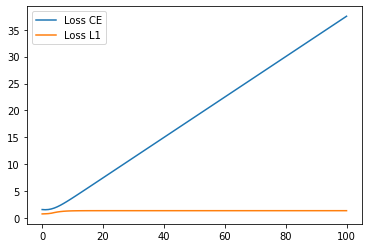

In [ ]:
Iter = 100
Loss_ce = torch.zeros(Iter+1)
Loss_l1 = torch.zeros(Iter+1)
Loss_ce[0] = loss_ce(q,p,l)
Loss_l1[0] = loss_l1(q,p,l)

for i in range(Iter):
  q = update_iter(q,p,l)
  Loss_ce[i+1] = loss_ce(q,p,l)
  Loss_l1[i+1] = loss_l1(q,p,l)

plt.plot(torch.arange(Iter+1),Loss_ce,label="Loss CE")
plt.plot(torch.arange(Iter+1),Loss_l1,label='Loss L1')
plt.legend()

In [ ]:
q0 = torch.matmul(torch.linalg.pinv(p),l)
q0 = q0/torch.sum(q0,axis=1,keepdims=True)

In [ ]:
q0

tensor([[ 0.7685,  0.3281,  0.0670, -0.1168, -0.0468],
        [-0.0950,  0.1443,  0.4013,  0.2899,  0.2595]])

In [ ]:
torch.matmul(p,q0)

tensor([[-0.0425,  0.1555,  0.3810,  0.2652,  0.2409],
        [ 0.4909,  0.2690,  0.1745,  0.0140,  0.0517],
        [ 0.0517,  0.1755,  0.3445,  0.2208,  0.2075]])

In [ ]:
loss_ce(q0,p,l)

tensor(1.3132)

In [ ]:
loss_l1(q0,p,l)

tensor(0.4956)

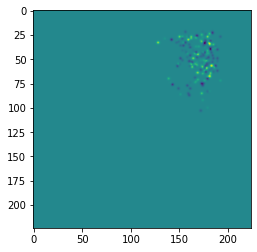

In [ ]:
plt.imshow(req[0,0,:,:])

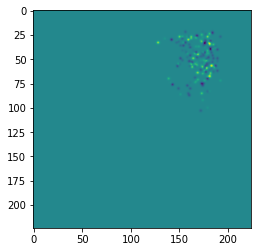

In [ ]:
plt.imshow(req[1,0,:,:])

In [ ]:
pred_heatmap = torch.matmul(cnn_prob,leaf_q) # (200,12*224*224)
pred_coord = find_coord(pred_heatmap)
pred_heatmap = pred_heatmap.reshape(200,12,224,224)*40
pred_heatmap[pred_heatmap<0.1]=0

In [ ]:
for i in range(200):
  print(torch.max(pred_heatmap[i,:,:,:]))

Text(0.5, 1.0, 'Coordinates')

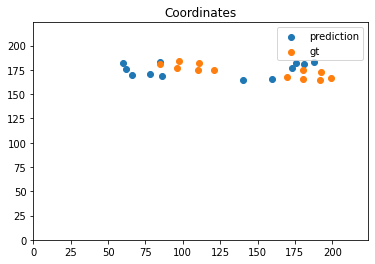

In [ ]:
nimg = 0
x = pred_coord[nimg,::2].cpu()
y = pred_coord[nimg,1::2].cpu()
plt.scatter(x,y,label="prediction")

x2 = train_label[nimg,72:96:2].cpu()
y2 = train_label[nimg,73:96:2].cpu()
plt.scatter(x2,y2,label="gt")

plt.legend()
plt.xlim(0,224)
plt.ylim(0,224)

plt.title("Coordinates")

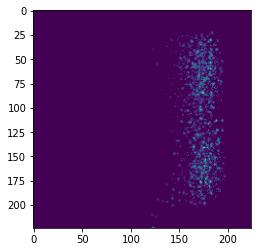

In [ ]:
nimg = 0
# predicted heatmap
plt.imshow(torch.sum(pred_heatmap[nimg,:,:,:],axis=0).cpu().detach().numpy())

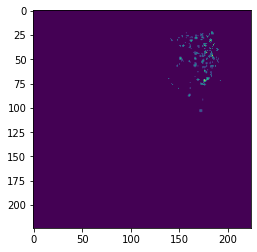

In [ ]:
plt.imshow(pred_heatmap[nimg,0,:,:].cpu().detach().numpy())

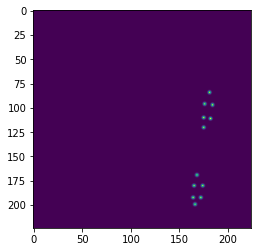

In [ ]:
# gt heatmap
plt.imshow(torch.sum(train_heatmap[nimg,36:48,:,:],axis=0).cpu())